In [2]:
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv("aluminium_raw_inputs.csv", parse_dates=['date']).sort_values('date')

In [ ]:
print("Date range:", df["date"].min(), "to", df["date"].max())
print("Number of observations (days):", len(df))
print("Number of features (excluding date):", df.shape[1] - 1)

missing_summary = df.isna().sum()
print("\nMissing values per column:\n", missing_summary[missing_summary > 0])

feature_list = df.columns.tolist()
print("\nFeatures:\n", feature_list)

Date range: 2015-06-01 00:00:00 to 2025-05-30 00:00:00
Number of observations (days): 2610
Number of features (excluding date): 46

Missing values per column:
 ('FeatureName.INVENTORY_STOCK', 'al_lme_closing_stock')    155
('FeatureName.INVENTORY_STOCK', 'al_comex_stocks')         155
('FeatureName.INVENTORY_STOCK', 'al_shfe_stocks')          155
('FeatureName.INVENTORY', 'al_lme_cancelled_warrants')     165
('FeatureName.INVENTORY', 'al_lme_delivered_out')          165
('FeatureName.INVENTORY', 'al_lme_delivered_in')           165
dtype: int64

Features:
 ['date', 'al_lme_prices', "('FeatureName.EXCHANGE_CURRENCY', 'us_dollar_index')", "('FeatureName.EXPORT_CURRENCY', 'canadian_dollar_spot')", "('FeatureName.EXPORT_CURRENCY', 'euro_spot')", "('FeatureName.EXPORT_CURRENCY', 'emirate_dirham_spot')", "('FeatureName.EXPORT_CURRENCY', 'russian_ruble_spot')", "('FeatureName.EXPORT_CURRENCY', 'indian_rupee_spot')", "('FeatureName.EXPORT_CURRENCY', 'nor_krone_spot')", "('FeatureName.EXPORT_CU

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv("aluminium_raw_inputs.csv", parse_dates=["date"]).sort_values("date")

df["log_returns"] = np.log(df["al_lme_prices"] / df["al_lme_prices"].shift(1))
df["vol"] = df["log_returns"].rolling(window=30).std(ddof=1) * np.sqrt(252)

df["target_vol"] = df["vol"].shift(-30)
df["target_log_vol"] = np.log(df["target_vol"]+ 1e-8)

df["lag1_vol"] = df["vol"].shift(1)
df["lag7_vol"] = df["vol"].shift(7)
df["lag30_vol"] = df["vol"].shift(30)

df = df.dropna().reset_index(drop=True)


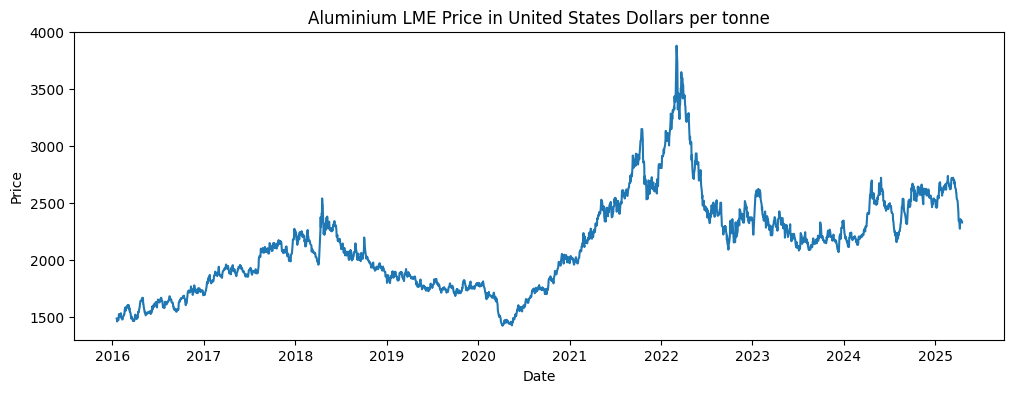

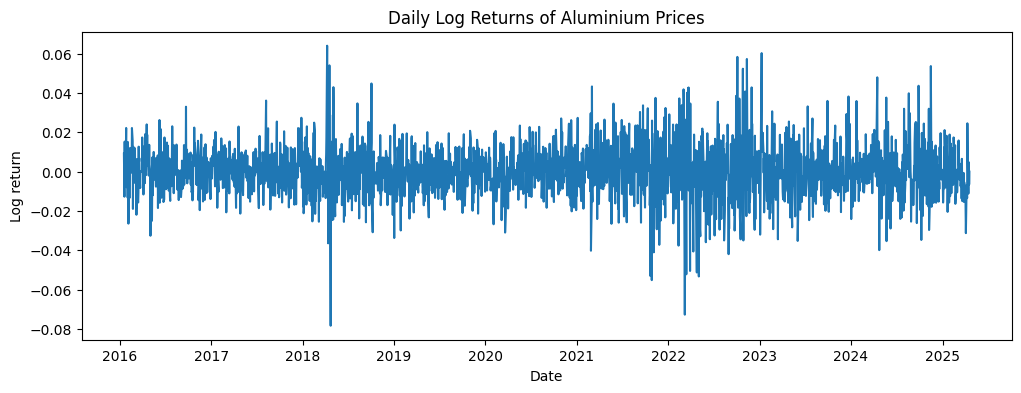

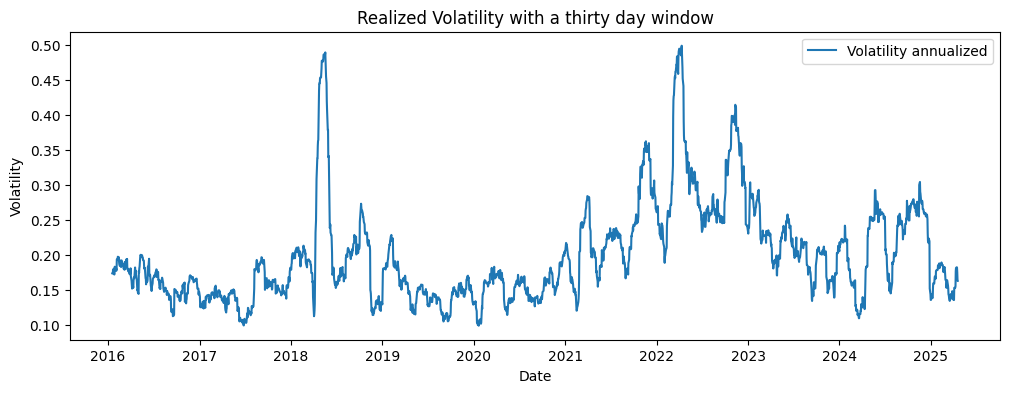

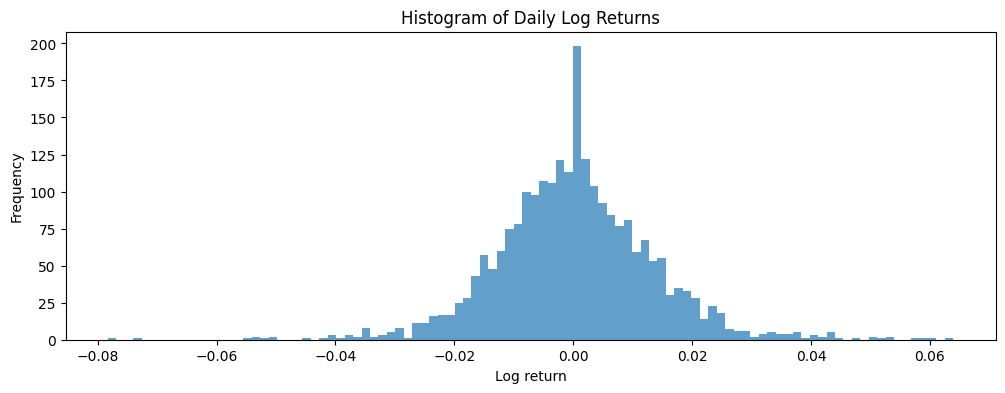

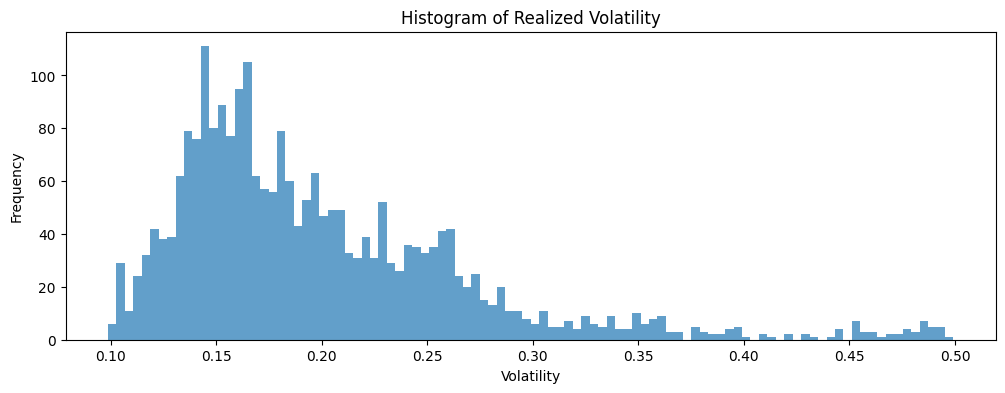

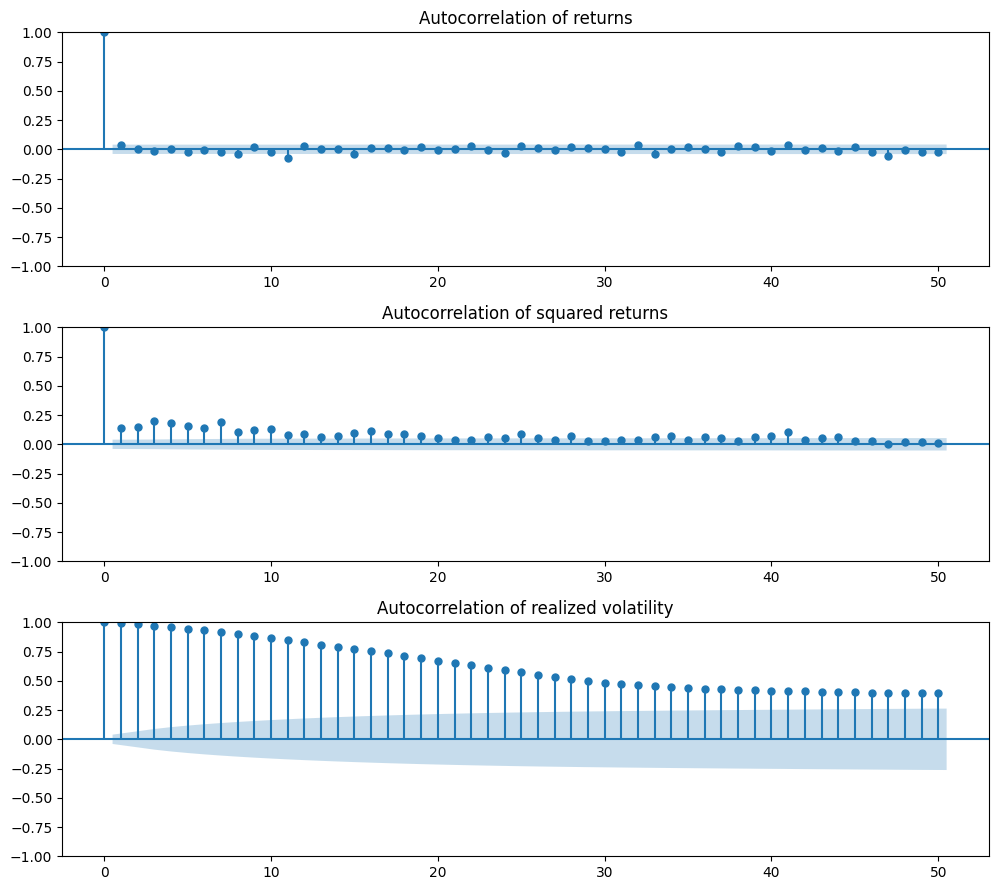

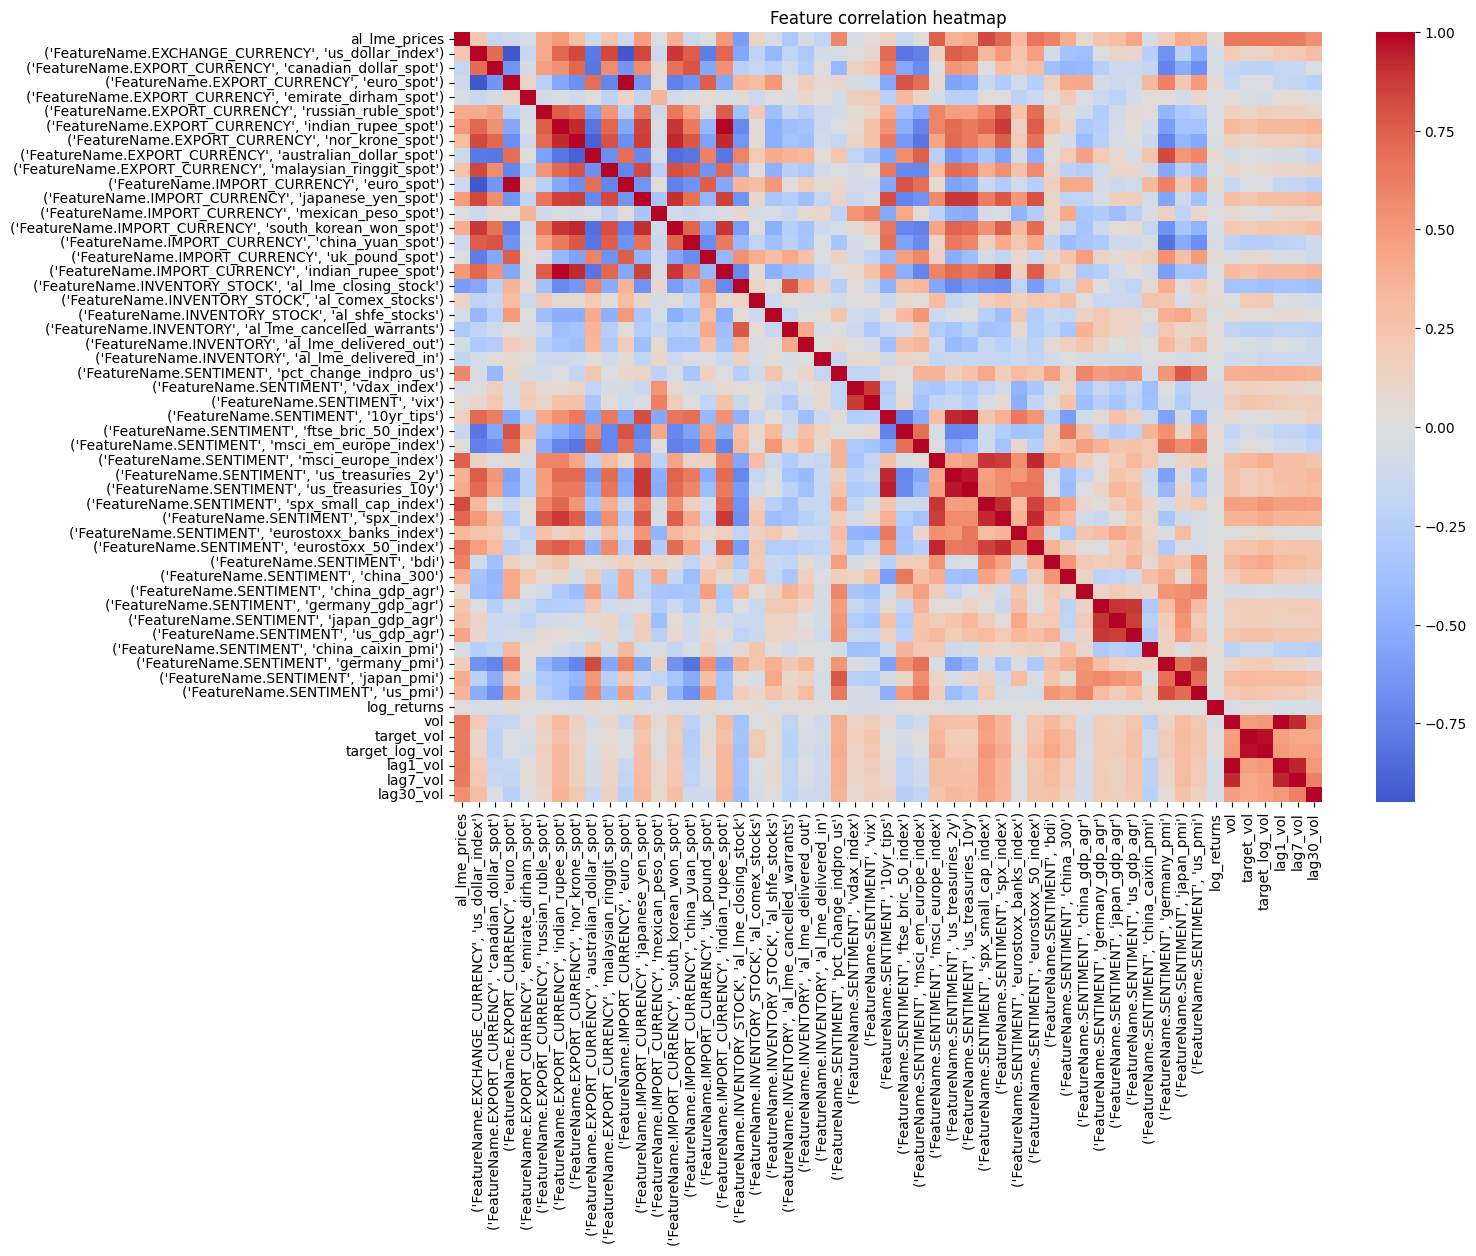

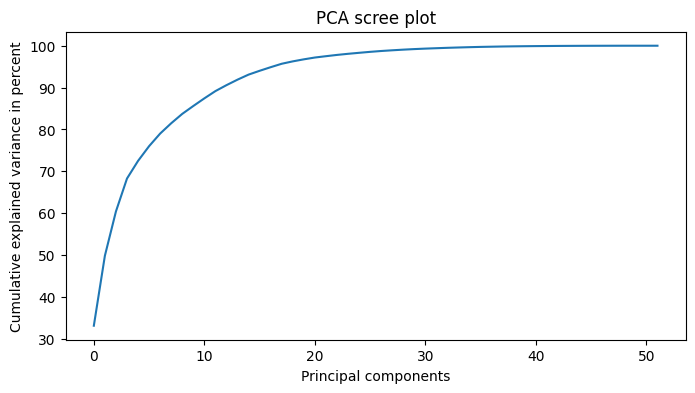

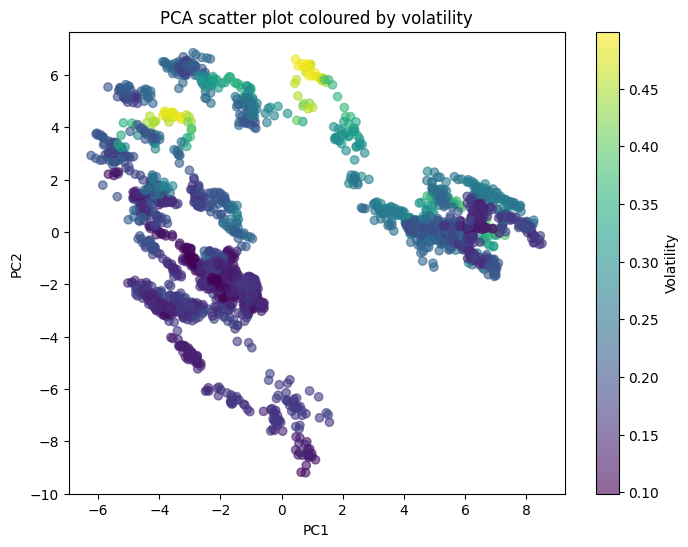

In [6]:

# --- 1) Aluminium price series
plt.figure(figsize=(12, 4))
plt.plot(df["date"], df["al_lme_prices"])
plt.title("Aluminium LME Price in United States Dollars per tonne")
plt.xlabel("Date"); plt.ylabel("Price")
plt.show()

# --- 2) Aluminium log returns
plt.figure(figsize=(12, 4))
plt.plot(df["date"], df["log_returns"])
plt.title("Daily Log Returns of Aluminium Prices")
plt.xlabel("Date"); plt.ylabel("Log return")
plt.show()

# --- 2) Realized volatility
plt.figure(figsize=(12, 4))
plt.plot(df["date"], df["vol"], label="Volatility annualized")
plt.title("Realized Volatility with a thirty day window")
plt.xlabel("Date"); plt.ylabel("Volatility"); plt.legend()
plt.show()

# --- 3) Histograms
plt.figure(figsize=(12, 4))
plt.hist(df["log_returns"], bins=100, alpha=0.7)
plt.title("Histogram of Daily Log Returns")
plt.xlabel("Log return"); plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12, 4))
plt.hist(df["vol"], bins=100, alpha=0.7)
plt.title("Histogram of Realized Volatility")
plt.xlabel("Volatility"); plt.ylabel("Frequency")
plt.show()

# --- 4) Autocorrelation functions
fig, axes = plt.subplots(3, 1, figsize=(10, 9))
sm.graphics.tsa.plot_acf(df["log_returns"], lags=50, ax=axes[0])
axes[0].set_title("Autocorrelation of returns")
sm.graphics.tsa.plot_acf(df["log_returns"]**2, lags=50, ax=axes[1])
axes[1].set_title("Autocorrelation of squared returns")
sm.graphics.tsa.plot_acf(df["vol"], lags=50, ax=axes[2])
axes[2].set_title("Autocorrelation of realized volatility")
plt.tight_layout()
plt.show()

# --- 5) Correlation heatmap
# Select numeric columns and compute correlations
corr_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(14, 10))
sns.heatmap(df[corr_cols].corr(), cmap="coolwarm", center=0)
plt.title("Feature correlation heatmap")
plt.show()

# --- 6) PCA on standardized features
# Exclude date and the prediction target when exploring driver structure
pca_cols = df.columns.difference(["date", "target_vol"])
X = df[pca_cols].dropna().select_dtypes(include=[np.number])
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_std)

# Scree plot
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100)
plt.ylabel("Cumulative explained variance in percent")
plt.xlabel("Principal components")
plt.title("PCA scree plot")
plt.show()

# Scatter plot of the first two components coloured by volatility
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=X["vol"].values[:len(X_pca)], cmap="viridis", alpha=0.6)
cbar = plt.colorbar()
cbar.set_label("Volatility")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA scatter plot coloured by volatility")
plt.show()


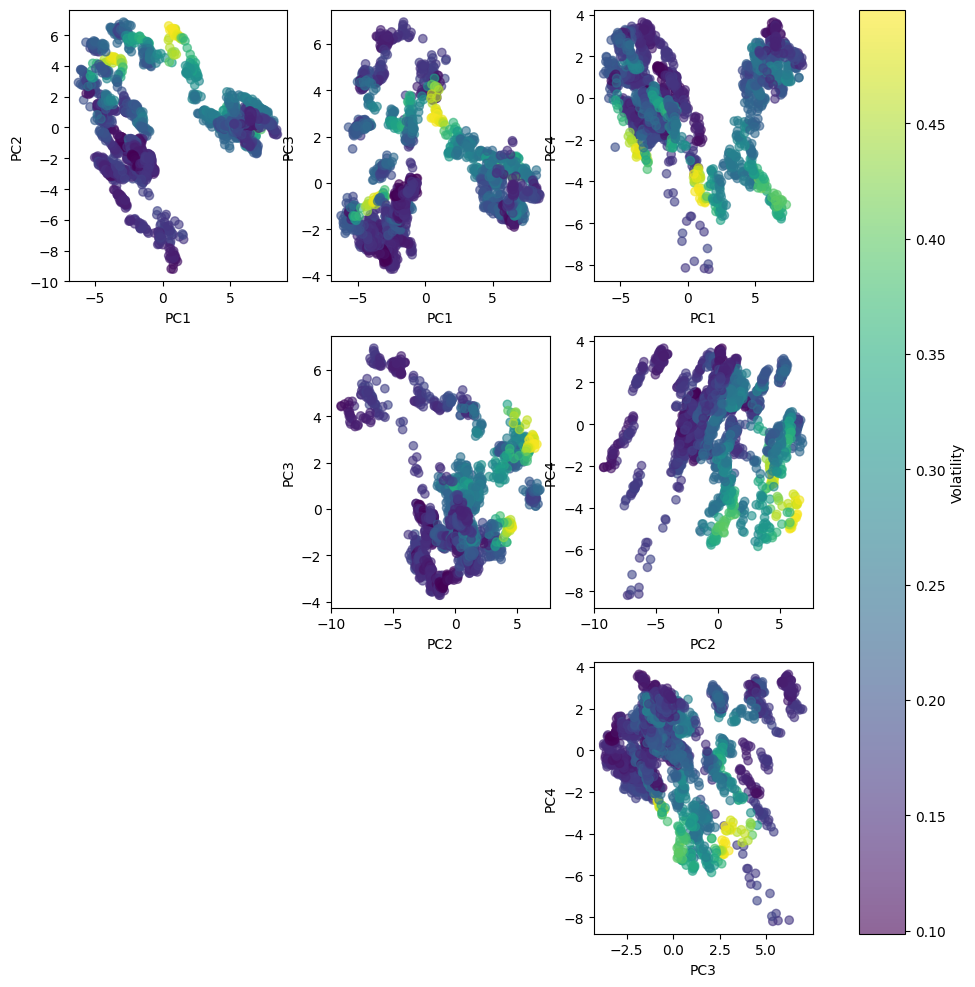

In [7]:
pcs_to_plot = 4
fig, axes = plt.subplots(pcs_to_plot-1, pcs_to_plot-1, figsize=(12,12))

for i in range(pcs_to_plot-1):
    for j in range(i+1, pcs_to_plot):
        ax = axes[i, j-1]
        sc = ax.scatter(X_pca[:, i], X_pca[:, j],
                        c=df["vol"].iloc[:len(X)], cmap="viridis", alpha=0.6)
        ax.set_xlabel(f"PC{i+1}")
        ax.set_ylabel(f"PC{j+1}")

# remove empty axes
for i in range(pcs_to_plot-1):
    for j in range(pcs_to_plot-1):
        if j < i:
            fig.delaxes(axes[i, j])

fig.colorbar(sc, ax=axes.ravel().tolist(), label="Volatility")
plt.show()


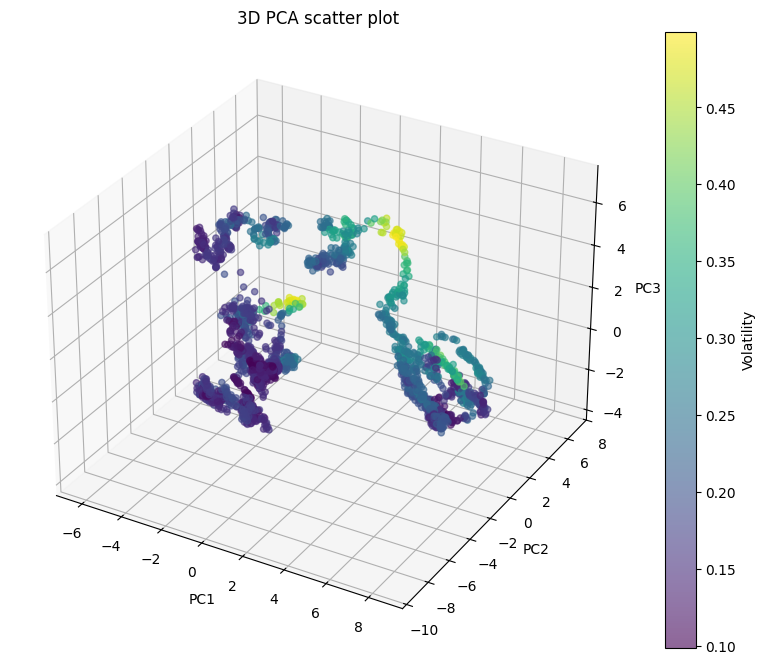

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2],
                c=df["vol"].iloc[:len(X)], cmap="viridis", alpha=0.6)
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
fig.colorbar(sc, ax=ax, label="Volatility")
plt.title("3D PCA scatter plot")
plt.show()


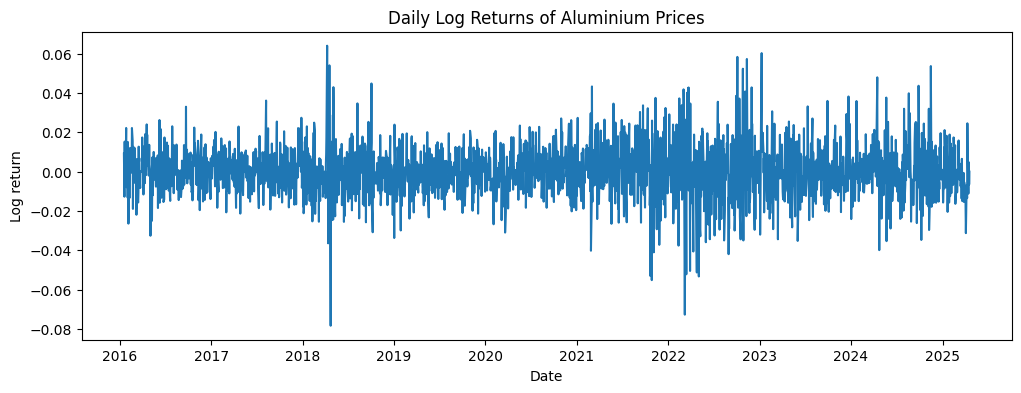

Saved: plots/correlation_heatmap_top.png
Saved: tables/top_correlations_with_target_vol.csv


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

os.makedirs("plots", exist_ok=True)

def savefig(path):
    plt.savefig(path, dpi=200, bbox_inches="tight")
    plt.close()

# --------------------------------------------------------------------------------------
# 1) Aluminium price series
# --------------------------------------------------------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(df["date"], df["al_lme_prices"])
plt.title("Aluminium LME Price in United States Dollars per tonne")
plt.xlabel("Date"); plt.ylabel("Price")
savefig("plots/price_series.png")
plt.show()

# --------------------------------------------------------------------------------------
# 1.5) Aluminium Log returns series
# --------------------------------------------------------------------------------------
plt.figure(figsize=(12,4))
plt.plot(df["date"], df["log_returns"])
plt.title("Daily Log Returns of Aluminium Prices")
plt.xlabel("Date"); plt.ylabel("Log return")
plt.savefig("plots/log_returns_series.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close()



# --------------------------------------------------------------------------------------
# 2) Realized volatility series
# --------------------------------------------------------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(df["date"], df["vol"], label="Volatility annualized")
plt.title("Realized Volatility with a thirty day window")
plt.xlabel("Date"); plt.ylabel("Volatility"); plt.legend()
savefig("plots/realized_volatility.png")
plt.show()

# --------------------------------------------------------------------------------------
# 3) Histograms
# --------------------------------------------------------------------------------------
plt.figure(figsize=(12, 4))
plt.hist(df["log_returns"], bins=100, alpha=0.7)
plt.title("Histogram of Daily Log Returns")
plt.xlabel("Log return"); plt.ylabel("Frequency")
savefig("plots/hist_log_returns.png")

plt.figure(figsize=(12, 4))
plt.hist(df["vol"], bins=100, alpha=0.7)
plt.title("Histogram of Realized Volatility")
plt.xlabel("Volatility"); plt.ylabel("Frequency")
savefig("plots/hist_volatility.png")
plt.show()


# --------------------------------------------------------------------------------------
# 4) Autocorrelation functions
# --------------------------------------------------------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(10, 9))
sm.graphics.tsa.plot_acf(df["log_returns"], lags=50, ax=axes[0])
axes[0].set_title("Autocorrelation of returns")
sm.graphics.tsa.plot_acf(df["log_returns"]**2, lags=50, ax=axes[1])
axes[1].set_title("Autocorrelation of squared returns")
sm.graphics.tsa.plot_acf(df["vol"], lags=50, ax=axes[2])
axes[2].set_title("Autocorrelation of realized volatility")
plt.tight_layout()
savefig("plots/acf_panels.png")
plt.show()


# --------------------------------------------------------------------------------------
# 5) Correlation heatmap
# --------------------------------------------------------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs("plots", exist_ok=True)
os.makedirs("tables", exist_ok=True)

num_df = df.select_dtypes(include=[np.number]).copy()

target_col = "target_vol"
assert target_col in num_df.columns, "target_vol not found in numeric columns."

corr_with_target = num_df.drop(columns=[target_col]).corrwith(num_df[target_col])

k = 15   
top_idx = corr_with_target.abs().sort_values(ascending=False).head(k).index

top_corr = corr_with_target.loc[top_idx].sort_values(key=np.abs, ascending=False)
top_corr_df = top_corr.reset_index()
top_corr_df.columns = ["feature", "corr_with_target_vol"]

top_corr_df.to_csv("tables/top_correlations_with_target_vol.csv", index=False)

# 3) Build a small correlation matrix among these features + target for context
cols_for_heatmap = list(top_idx) + [target_col]
cmat = num_df[cols_for_heatmap].corr()

# 4) Plot a labeled heatmap
plt.figure(figsize=(1.0 + 0.5*len(cols_for_heatmap), 1.0 + 0.5*len(cols_for_heatmap)))
ax = sns.heatmap(
    cmat,
    cmap="coolwarm",
    center=0,
    vmin=-1, vmax=1,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation matrix for top features by absolute correlation with target volatility")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("plots/correlation_heatmap_top.png", dpi=200, bbox_inches="tight")
plt.close()

print("Saved: plots/correlation_heatmap_top.png")
print("Saved: tables/top_correlations_with_target_vol.csv")


# --------------------------------------------------------------------------------------
# 6) PCA: scree and PC1 vs PC2 scatter coloured by volatility
# --------------------------------------------------------------------------------------
pca_cols = df.columns.difference(["date", "target_vol"])
X = df[pca_cols].select_dtypes(include=[np.number]).copy()
X_std = StandardScaler().fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_std)

evr = pca.explained_variance_ratio_
n_pc = min(20, len(evr))
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_pc+1), evr[:n_pc]*100, alpha=0.7)
plt.plot(range(1, n_pc+1), np.cumsum(evr[:n_pc])*100, marker="o")
plt.xlabel("Principal component"); plt.ylabel("Explained variance in percent")
plt.title("Explained variance per principal component")
plt.xticks(range(1, n_pc+1))
plt.legend(["Cumulative variance", "Individual variance"])
savefig("plots/pca_explained_variance_first20.png")
plt.show()


# PC1 vs PC2
plt.figure(figsize=(8, 6))
sc = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["vol"].values, cmap="viridis", alpha=0.6)
cbar = plt.colorbar(sc); cbar.set_label("Volatility")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA scatter: PC1 versus PC2 coloured by volatility")
savefig("plots/pca_scatter_pc1_pc2.png")
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

rets = df["log_returns"].dropna()

mu, sigma = rets.mean(), rets.std()

plt.figure(figsize=(12,4))
count, bins, _ = plt.hist(rets, bins=100, density=True, alpha=0.6, color="steelblue", label="Empirical")

# fitted Gaussian pdf
x = np.linspace(rets.min(), rets.max(), 1000)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, "r-", lw=2, label=f"Normal($\\mu={mu:.4f}$, $\\sigma={sigma:.4f}$)")

plt.title("Distribution of Daily Log Returns vs Normal Fit")
plt.xlabel("Log return")
plt.ylabel("Density")
plt.legend()
plt.savefig("plots/hist_log_returns_vs_normal.png", dpi=200, bbox_inches="tight")
plt.close()


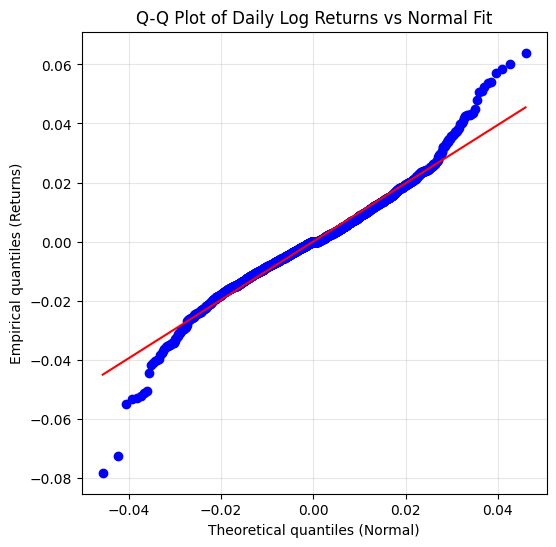

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# log returns
rets = df["log_returns"].dropna()

# fit Gaussian with same mean and std
mu, sigma = rets.mean(), rets.std()

# Q-Q plot
plt.figure(figsize=(6,6))
stats.probplot(rets, dist="norm", sparams=(mu, sigma), plot=plt)
plt.title("Q-Q Plot of Daily Log Returns vs Normal Fit")
plt.xlabel("Theoretical quantiles (Normal)")
plt.ylabel("Empirical quantiles (Returns)")
plt.grid(True, alpha=0.3)
plt.savefig("plots/qq_log_returns_vs_normal.png", dpi=200, bbox_inches="tight")
plt.show()


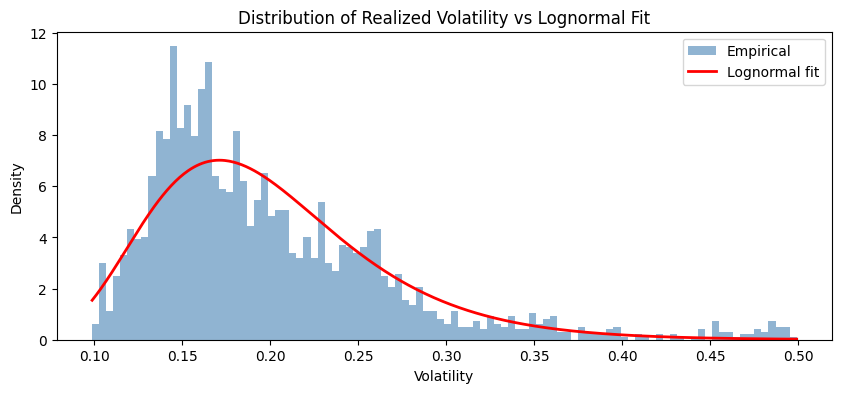

In [12]:
from scipy.stats import lognorm

vols = df["vol"].dropna()
shape, loc, scale = lognorm.fit(vols, floc=0)  # lognormal fit

x = np.linspace(vols.min(), vols.max(), 500)
pdf = lognorm.pdf(x, shape, loc, scale)

plt.figure(figsize=(10,4))
plt.hist(vols, bins=100, density=True, alpha=0.6, color="steelblue", label="Empirical")
plt.plot(x, pdf, "r-", lw=2, label="Lognormal fit")
plt.title("Distribution of Realized Volatility vs Lognormal Fit")
plt.xlabel("Volatility"); plt.ylabel("Density")
plt.legend()
plt.savefig("plots/hist_volatility_vs_lognormal.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close()


In [ ]:

# PCA by category + plots

import os, re
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


# 1) Helpers: category parsing

def extract_category(colname: str):
    """
    Extract clean category like EXPORT_CURRENCY, IMPORT_CURRENCY, SENTIMENT, etc.
    Works for strings like "('FeatureName.SENTIMENT', 'vix')".
    """
    m = re.match(r"\('FeatureName\.([A-Za-z0-9_]+)'\s*,", str(colname))
    return m.group(1) if m else None



# 2) PCA per category

def run_pca_by_category(
    df: pd.DataFrame,
    target_col: str = "target_log_vol",
    corr_threshold: float = 0.10,
    var_threshold: float = 0.80,
    min_cols: int = 2,
    min_rows: int = 50,
):
    """
    For each category, standardize its columns, run PCA, compute:
      - explained variance ratios,
      - correlation of each PC with target,
      - kept PCs (|corr| >= corr_threshold) or fallback to var_threshold.
    Returns:
      summaries: dict[category] -> metadata (evr, cum_evr, keep_idx, etc.)
      kept_pc_df: DataFrame with only kept PCs, columns like "{CAT}_PC{j}"
      all_pc_df:  DataFrame with ALL PCs per category (first P), same naming
                  (so plotting in mode='first' can always use PC1..PCk).
    """
    summaries = {}
    kept_pc_df_parts = []
    all_pc_df_parts  = []

    # Group columns by category
    categories = {}
    for c in df.columns:
        cat = extract_category(c)
        if cat:
            categories.setdefault(cat, []).append(c)

    for cat, cols in categories.items():
        # Build a clean matrix for this category + target
        cols_plus = [c for c in cols if c in df.columns]
        sub = df[cols_plus + [target_col]].dropna()
        if sub.shape[0] < min_rows or len(cols_plus) < min_cols:
            continue

        X = sub[cols_plus].to_numpy(dtype=np.float64)
        y = sub[target_col].to_numpy(dtype=np.float64)

        # Standardize features for PCA
        Xs = StandardScaler().fit_transform(X)

        pca = PCA().fit(Xs)
        comps = pca.transform(Xs)  # shape (n, p)
        evr = pca.explained_variance_ratio_

        # Corr(PC_i, target)
        cors = np.array([np.corrcoef(comps[:, i], y)[0, 1] for i in range(comps.shape[1])])
        cors = np.nan_to_num(cors, nan=0.0)

        # Keep rule: correlation first, else variance fallback
        keep_idx = [i for i, c in enumerate(cors) if abs(c) >= corr_threshold]
        if not keep_idx:
            keep_idx = list(np.where(np.cumsum(evr) <= var_threshold)[0])

        summaries[cat] = {
            "columns": cols_plus,
            "n_cols": len(cols_plus),
            "n_rows_used": sub.shape[0],
            "evr": evr,                 # per-PC variance explained
            "cum_evr": np.cumsum(evr),  # cumulative
            "cors": cors,               # per-PC correlation with target
            "keep_idx": keep_idx,       # which PCs kept
            "n_keep": len(keep_idx),
            "n_all": comps.shape[1],
            "index": sub.index,         # alignment
        }

        # Add ALL PCs (enables 'first' plotting mode)
        for j in range(comps.shape[1]):
            all_pc_df_parts.append(pd.Series(comps[:, j], index=sub.index, name=f"{cat}_PC{j+1}"))

        # Add kept PCs
        for j in keep_idx:
            kept_pc_df_parts.append(pd.Series(comps[:, j], index=sub.index, name=f"{cat}_PC{j+1}"))

    # Build aligned DataFrames (outer join, then sort index)
    all_pc_df  = pd.concat(all_pc_df_parts,  axis=1) if all_pc_df_parts  else pd.DataFrame(index=df.index)
    kept_pc_df = pd.concat(kept_pc_df_parts, axis=1) if kept_pc_df_parts else pd.DataFrame(index=df.index)

    # Reindex to full df (keep original index alignment), sort for neatness
    all_pc_df  = all_pc_df.reindex(df.index).sort_index()
    kept_pc_df = kept_pc_df.reindex(df.index).sort_index()

    return summaries, kept_pc_df, all_pc_df


# 3) Plot per-category PCA summaries
def plot_pca_summaries(summaries: dict, outdir="plots/pca", max_pcs_plot: int = 15):
    """
    For each category, save a bar+line plot:
      - Bars: explained variance ratio per PC
      - Line: cumulative explained variance
      - Kept PCs highlighted
    Also returns a small DataFrame with n_keep and total cols per category.
    """
    os.makedirs(outdir, exist_ok=True)
    overview_rows = []

    for cat, s in summaries.items():
        evr     = s["evr"]
        cum_evr = s["cum_evr"]
        keep    = set(s["keep_idx"])
        p = len(evr)

        m = min(p, max_pcs_plot)

        fig, ax1 = plt.subplots(figsize=(10, 4.5))
        bars = ax1.bar(np.arange(m), evr[:m], alpha=0.7, label="Explained variance (per PC)")
        ax1.set_ylabel("Explained variance ratio")
        ax1.set_xlabel("Principal component index (1-based)")
        ax1.set_xticks(np.arange(m))
        ax1.set_xticklabels([str(i+1) for i in range(m)], rotation=0)

        # Highlight kept PCs
        for i in range(m):
            if i in keep:
                bars[i].set_alpha(1.0)
                bars[i].set_hatch("//")

        ax2 = ax1.twinx()
        ax2.plot(np.arange(m), cum_evr[:m], linewidth=2)
        ax2.set_ylabel("Cumulative EVR")

        ax1.set_title(f"{cat}: kept {s['n_keep']} PC(s) (of {s['n_cols']} cols); rows used={s['n_rows_used']}")
        ax1.grid(alpha=0.25)

        h1 = bars[0]
        h2 = ax2.lines[0]
        ax1.legend([h1, h2], ["Per-PC EVR", "Cumulative EVR"], loc="upper right")

        out = os.path.join(outdir, f"pca_{cat}.png")
        plt.tight_layout()
        plt.savefig(out, dpi=200, bbox_inches="tight")
        plt.close()

        overview_rows.append({"category": cat, "n_cols": s["n_cols"], "n_keep": s["n_keep"]})

    overview = pd.DataFrame(overview_rows).sort_values(["n_keep", "n_cols"], ascending=[False, False]).reset_index(drop=True)
    if not overview.empty:
        plt.figure(figsize=(10, 4))
        plt.bar(overview["category"], overview["n_keep"])
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("# PCs kept")
        plt.title("PCs kept per category")
        plt.tight_layout()
        plt.savefig(os.path.join(outdir, "pca_overview_kept_counts.png"), dpi=200, bbox_inches="tight")
        plt.close()

    return overview


# 4) Plot PC space vs target
def _closest_key(name, keys):
    if name in keys: 
        return name
    low = {k.lower(): k for k in keys}
    return low.get(name.lower())

def plot_pc_space_colored_by_target(
    df, summaries, kept_pc_df, all_pc_df, selection,
    target_col="target_log_vol",
    outdir="plots/pca_selected_space",
    quantiles=(0.33, 0.67),
    cmap=('tab:blue','lightgray','tab:red'),
    alpha=0.7, s=16,
    mode="keep"   # "keep" = use keep_idx from summaries, "first" = use first n PCs from ALL PCs
):
    """
    For each category in `selection`, plot the data in the space of the selected PCs:
      - n=1: 1D strip at x=PC1 (with tiny jitter on y), colored by target bins
      - n=2: 2D scatter PC1 vs PC2
      - n=3: 3D scatter PC1 vs PC2 vs PC3
      - n>3: uses first 3 PCs
    """
    os.makedirs(outdir, exist_ok=True)

    tgt = df[target_col].dropna()
    q_low, q_high = np.quantile(tgt.values, quantiles)
    def _bin_target(y):
        return np.where(y <= q_low, 0, np.where(y >= q_high, 2, 1))

    for cat, n_keep_req in selection.items():
        cat_key = _closest_key(cat, summaries.keys())
        if not cat_key:
            print(f"[WARN] Category '{cat}' not found.")
            continue

        # Choose PCs
        if mode == "first":
            chosen = list(range(int(n_keep_req)))  # PC indices 0..n-1
            source_df = all_pc_df
        else:
            keep_idx_sorted = sorted(summaries[cat_key]["keep_idx"])
            chosen = keep_idx_sorted[:int(n_keep_req)]
            source_df = kept_pc_df

        if not chosen:
            print(f"[WARN] Category '{cat}' has no PCs chosen. Skipping.")
            continue

        if len(chosen) > 3:
            print(f"[INFO] {cat}: requested {len(chosen)} PCs; plotting only first 3.")
            chosen = chosen[:3]

        pc_cols = [f"{cat_key}_PC{j+1}" for j in chosen]
        available = [c for c in pc_cols if c in source_df.columns]
        if len(available) < len(pc_cols):
            print(f"[WARN] Some PCs missing for {cat}. Available: {available}")
            pc_cols = available
        if len(pc_cols) == 0:
            continue

        PCs = source_df[pc_cols].dropna()
        idx = tgt.index.intersection(PCs.index)
        if len(idx) == 0:
            print(f"[WARN] No overlap rows for {cat}.")
            continue

        X = PCs.loc[idx].values
        y = tgt.loc[idx].values
        ybin = _bin_target(y)
        colors = np.array(cmap, dtype=object)[ybin]

        if len(pc_cols) == 1:
            x = X[:,0]; rng = np.random.default_rng(0)
            yj = rng.normal(0, 0.02, len(x))
            plt.figure(figsize=(8,3))
            plt.scatter(x, yj, c=colors, s=s, alpha=alpha, edgecolors='none')
            plt.yticks([]); plt.xlabel(pc_cols[0])
            plt.title(f"{cat_key}: PC1 vs {target_col}\nlow ≤ {q_low:.3f}, mid ∈ ({q_low:.3f},{q_high:.3f}), high ≥ {q_high:.3f}")
            for label,c in zip(['low','mid','high'], cmap):
                plt.scatter([],[],c=c,label=label)
            plt.legend()
            plt.savefig(f"{outdir}/{cat_key}_PCspace_1D.png", dpi=200, bbox_inches="tight"); plt.close()

        elif len(pc_cols) == 2:
            plt.figure(figsize=(6.5,5.5))
            plt.scatter(X[:,0], X[:,1], c=colors, s=s, alpha=alpha, edgecolors='none')
            plt.xlabel(pc_cols[0]); plt.ylabel(pc_cols[1])
            plt.title(f"{cat_key}: PC1–PC2 vs {target_col}\nlow ≤ {q_low:.3f}, mid ∈ ({q_low:.3f},{q_high:.3f}), high ≥ {q_high:.3f}")
            for label,c in zip(['low','mid','high'], cmap):
                plt.scatter([],[],c=c,label=label)
            plt.legend(); plt.grid(alpha=0.25)
            plt.savefig(f"{outdir}/{cat_key}_PCspace_2D.png", dpi=200, bbox_inches="tight"); plt.close()

        else:  # 3D
            fig = plt.figure(figsize=(7.5,6.5))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(X[:,0], X[:,1], X[:,2], c=colors, s=s, alpha=alpha)
            ax.set_xlabel(pc_cols[0]); ax.set_ylabel(pc_cols[1]); ax.set_zlabel(pc_cols[2])
            ax.set_title(f"{cat_key}: PC1–PC3 vs {target_col}\nlow ≤ {q_low:.3f}, mid ∈ ({q_low:.3f},{q_high:.3f}), high ≥ {q_high:.3f}")
            for label,c in zip(['low','mid','high'], cmap):
                ax.scatter([],[],[],c=c,label=label)
            ax.legend()
            plt.savefig(f"{outdir}/{cat_key}_PCspace_3D.png", dpi=200, bbox_inches="tight"); plt.close()



# 5a) Build PCA outputs
summaries, kept_pc_df, all_pc_df = run_pca_by_category(
    df,
    target_col="target_log_vol",
    corr_threshold=0.10,   # tweak as you like
    var_threshold=0.80,    # fallback threshold
)

# 5b) Summary plots
overview = plot_pca_summaries(summaries, outdir="plots/pca", max_pcs_plot=15)
print(overview.head(10))
print("Saved per-category PCA plots to plots/pca/")

# 5c) PC-space plots 
selection = {
    "EXPORT_CURRENCY": 1,
    "IMPORT_CURRENCY": 1,
    "INVENTORY_STOCK": 3,  # will be true 3D if ≥3 PCs exist
    "INVENTORY": 2,
    "SENTIMENT": 2,
}

plot_pc_space_colored_by_target(
    df, summaries, kept_pc_df, all_pc_df, selection,
    target_col="target_log_vol", mode="first"
)


          category  n_cols  n_keep
0        SENTIMENT      23       9
1  EXPORT_CURRENCY       8       6
2  IMPORT_CURRENCY       7       5
3        INVENTORY       3       3
4  INVENTORY_STOCK       3       2
Saved per-category PCA plots to plots/pca/


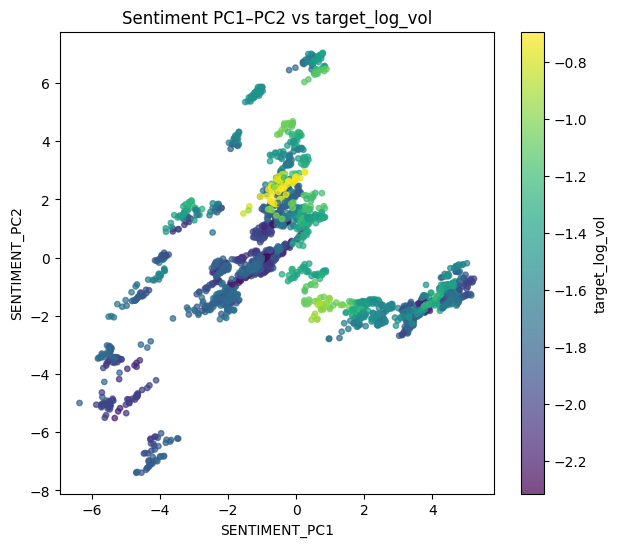

In [14]:
import matplotlib.pyplot as plt

# Pick target and PCs
target = df["target_log_vol"].dropna()
pc_cols = ["SENTIMENT_PC1", "SENTIMENT_PC2"]

# make sure those columns exist
avail = [c for c in pc_cols if c in all_pc_df.columns]
if len(avail) < 2:
    raise ValueError(f"Not all 2 sentiment PCs available. Found: {avail}")

PCs = all_pc_df[avail].dropna()
idx = target.index.intersection(PCs.index)

X = PCs.loc[idx].values
y = target.loc[idx].values

# color scale: continuous viridis
fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", s=15, alpha=0.7)

ax.set_xlabel("SENTIMENT_PC1")
ax.set_ylabel("SENTIMENT_PC2")
ax.set_title("Sentiment PC1–PC2 vs target_log_vol")
plt.colorbar(sc, ax=ax, label="target_log_vol")
plt.savefig("plots/sentiment_pc1_pc2_colored_by_target_log_vol.png", dpi=200, bbox_inches="tight")
plt.show()


/cs/student/projects1/dsml/2024/eborso/project_venv/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001586. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


[Saved] plots/engineered_vs_target_correlations_train.csv


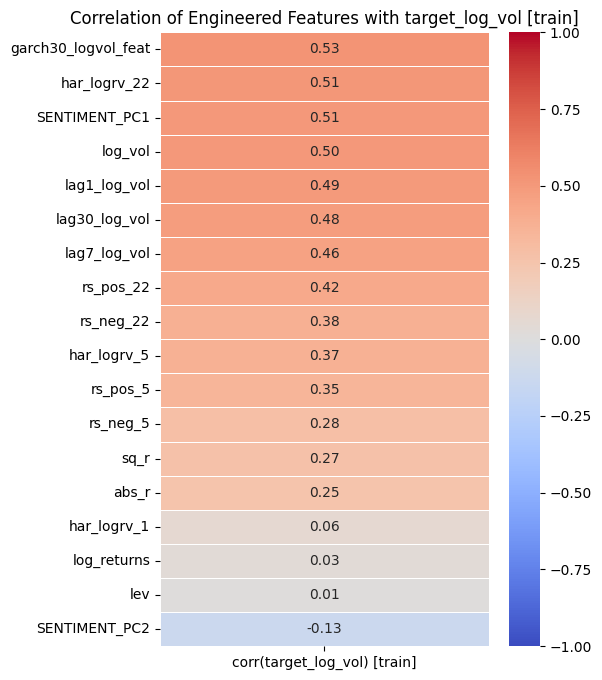

In [ ]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

# Config knobs
CSV_PATH     = "aluminium_raw_inputs.csv"
PLOTS_DIR    = "plots"; os.makedirs(PLOTS_DIR, exist_ok=True)
H            = 30
SEMI_KS      = [5, 22]
HAR_KS       = [1, 5, 22]
TRAIN_FRAC   = 0.70      # train fraction
VAL_FRAC     = 0.15      # validation fraction; remainder = test
SCOPE        = "train"   # choose: 'train' or 'test' for correlation slice
FIT_PCA_ON   = "train"   # fit sentiment PCA on 'train' (matches training notebook)

# Load + base
df = pd.read_csv(CSV_PATH, parse_dates=["date"]).sort_values("date").reset_index(drop=True)

# Core returns
df["log_returns"] = np.log(df["al_lme_prices"] / df["al_lme_prices"].shift(1))

# Backward-looking 30d realized vol and log
df["vol"]         = df["log_returns"].rolling(30).std() * np.sqrt(252.0)
df["log_vol"]     = np.log(df["vol"] + 1e-12)

# Forward target: NEXT 30d realized vol (log)
df["target_vol"]      = df["vol"].shift(-H)
df["target_log_vol"]  = np.log(df["target_vol"] + 1e-12)

# Engineered features
r = df["log_returns"].astype(float)

# shocks
df["abs_r"]  = r.abs()
df["sq_r"]   = r**2
df["sign_r"] = np.sign(r).replace({0.0: 0.0})
df["lev"]    = df["sign_r"] * df["sq_r"]

# semivariances
for k in SEMI_KS:
    neg = (r < 0).astype(float); pos = (r > 0).astype(float)
    df[f"rs_neg_{k}"] = (df["sq_r"] * neg).rolling(k).mean()
    df[f"rs_pos_{k}"] = (df["sq_r"] * pos).rolling(k).mean()

# HAR-style log RV (daily/weekly/monthly)
for k in HAR_KS:
    df[f"har_logrv_{k}"] = np.log(df["sq_r"].rolling(k).mean() * 252.0 + 1e-12)

# lagged log-vol (no leakage)
df["lag1_log_vol"]  = df["log_vol"].shift(1)
df["lag7_log_vol"]  = df["log_vol"].shift(7)
df["lag30_log_vol"] = df["log_vol"].shift(30)

# Build splits by date index
n    = len(df)
n_tr = int(np.floor(n * TRAIN_FRAC))
n_va = int(np.floor(n * VAL_FRAC))
n_te = n - n_tr - n_va
idx_train = np.arange(0, n_tr)
idx_val   = np.arange(n_tr, n_tr + n_va)
idx_test  = np.arange(n_tr + n_va, n)

# Sentiment PCA (fit on TRAIN, transform full)
sent_cols = [c for c in df.columns if "SENTIMENT" in c.upper()]
if not sent_cols:
    keys = ["VIX","VDAX","MSCI","SPX","EUROSTOXX","BRIC","BDI","BANKS"]
    sent_cols = [c for c in df.columns if any(k in c.upper() for k in keys)]

if len(sent_cols) >= 2:
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA

    X_fit = df.loc[idx_train, sent_cols] if FIT_PCA_ON == "train" else df[sent_cols]
    fit_means = X_fit.mean(skipna=True)
    X_fit_filled = X_fit.fillna(fit_means)

    scaler = StandardScaler().fit(X_fit_filled.to_numpy(dtype=np.float64))
    pca = PCA(n_components=min(2, len(sent_cols)), random_state=0).fit(
        scaler.transform(X_fit_filled.to_numpy(dtype=np.float64))
    )

    # transform full timeline with train-fitted scaler & PCA
    X_full = df[sent_cols].fillna(fit_means).to_numpy(dtype=np.float64)
    PCs_full = pca.transform(scaler.transform(X_full))
    df["SENTIMENT_PC1"] = PCs_full[:, 0]
    if PCs_full.shape[1] > 1:
        df["SENTIMENT_PC2"] = PCs_full[:, 1]

# GARCH(1,1) feature for ENTIRE SERIES (frozen params)

returns_full = df["log_returns"].to_numpy(dtype=float)
start_idx = int(np.argmax(np.isfinite(returns_full)))
train_slice = returns_full[max(start_idx, 1):n_tr]  # start from 1 to have r_{t-1} defined

df["garch30_logvol_feat"] = np.nan
if train_slice.size >= 30:
    am  = arch_model(train_slice, mean='Zero', vol='Garch', p=1, q=1, dist='normal')
    res = am.fit(disp='off')

    omega = float(res.params['omega'])
    alpha = float(res.params['alpha[1]'])
    beta  = float(res.params['beta[1]'])
    ab    = alpha + beta

    sigma2_t = float(res.conditional_volatility[0]**2)
    for t in range(max(start_idx+1, 1), n_tr):
        r_prev   = returns_full[t-1]
        if not np.isfinite(r_prev): 
            continue
        sigma2_t = omega + alpha*(r_prev**2) + beta*sigma2_t
        s = sigma2_t
        path = np.empty(H, dtype=float)
        for h in range(H):
            s = omega + ab * s
            path[h] = s
        avg_var   = float(path.mean())
        vol_30    = np.sqrt(avg_var) * np.sqrt(252.0)
        df.at[t, "garch30_logvol_feat"] = np.log(vol_30 + 1e-8)

    sigma2_t = float(res.conditional_volatility[-1]**2)
    for t in range(n_tr, n):
        r_prev   = returns_full[t-1]
        if not np.isfinite(r_prev): 
            continue
        sigma2_t = omega + alpha*(r_prev**2) + beta*sigma2_t
        s = sigma2_t
        path = np.empty(H, dtype=float)
        for h in range(H):
            s = omega + ab * s
            path[h] = s
        avg_var   = float(path.mean())
        vol_30    = np.sqrt(avg_var) * np.sqrt(252.0)
        df.at[t, "garch30_logvol_feat"] = np.log(vol_30 + 1e-8)
else:
    print(f"[GARCH] Not enough train data to fit (got {train_slice.size}). Skipping GARCH feature.")

# Correlations
engineered_cols = [
    "abs_r","sq_r","lev",
    "rs_neg_5","rs_pos_5","rs_neg_22","rs_pos_22",
    "har_logrv_1","har_logrv_5","har_logrv_22",
    "log_vol","lag1_log_vol","lag7_log_vol","lag30_log_vol",
    "log_returns",
    "garch30_logvol_feat"  
]
if "SENTIMENT_PC1" in df.columns: engineered_cols.append("SENTIMENT_PC1")
if "SENTIMENT_PC2" in df.columns: engineered_cols.append("SENTIMENT_PC2")

if SCOPE == "train":
    row_idx = idx_train
elif SCOPE == "test":
    row_idx = idx_test
else:
    raise ValueError("SCOPE must be 'train' or 'test'.")

sub = df.loc[row_idx, engineered_cols + ["target_log_vol"]].dropna()
corr_series = (
    sub.corr(numeric_only=True)["target_log_vol"]
       .drop(labels=["target_log_vol"])
       .sort_values(ascending=False)
)

# Save + plot
out_csv = os.path.join(PLOTS_DIR, f"engineered_vs_target_correlations_{SCOPE}.csv")
corr_series.to_csv(out_csv, header=["corr_with_target"])
print(f"[Saved] {out_csv}")

fig_h = 0.3 * max(len(corr_series), 5) + 1.5; fig_w = 6
title = f"Correlation of Engineered Features with target_log_vol [{SCOPE}]"
if _HAS_SNS:
    plt.figure(figsize=(fig_w, fig_h))
    sns.heatmap(
        corr_series.to_frame(name=f"corr(target_log_vol) [{SCOPE}]"),
        annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, cbar=True, linewidths=0.5
    )
    plt.title(title); plt.xlabel(""); plt.ylabel("")
    plt.tight_layout()
    plt.savefig(f"plots/engineered_vs_target_correlations_{SCOPE}.png")
    plt.show()
else:
    plt.figure(figsize=(fig_w, fig_h))
    y = np.arange(len(corr_series))
    plt.barh(y, corr_series.values); plt.yticks(y, corr_series.index)
    plt.gca().invert_yaxis()
    plt.xlabel(f"corr(target_log_vol) [{SCOPE}]"); plt.title(title)
    plt.tight_layout()
    plt.savefig(f"plots/engineered_vs_target_correlations_{SCOPE}.png")
    plt.show()


In [ ]:
# 2) PCA per category (TRAIN)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def run_pca_by_category_train(
    df: pd.DataFrame,
    train_idx: np.ndarray,
    target_col: str = "target_log_vol",
    min_cols: int = 2,
    min_rows: int = 50,
    n_pcs_store: int = 2,   # store PC1..PCn for the correlation table
):
    """
    Fit StandardScaler and PCA on TRAIN ONLY for each category.
    Compute correlations corr(PCj, target) on TRAIN ONLY.
    Return:
      - pc_corrs_train: tidy DataFrame [category, PC, corr_train]
      - pc_models: dict with scaler, pca per category (if you need to transform full)
      - all_pc_df:  DataFrame with PC1..PCn (per category) on FULL index (NaN outside rows used)
    """
    # Build category mapping
    categories = {}
    for c in df.columns:
        cat = extract_category(c)
        if cat:
            categories.setdefault(cat, []).append(c)

    pc_models = {}
    pc_corr_rows = []
    all_pc_df_parts = []

    for cat, cols in categories.items():
        cols = [c for c in cols if c in df.columns]
        if len(cols) < min_cols:
            continue

        # TRAIN slice for this category (drop NaNs jointly in features+target)
        train_sub = df.loc[train_idx, cols + [target_col]].dropna()
        if train_sub.shape[0] < min_rows:
            continue

        X_train = train_sub[cols].to_numpy(dtype=np.float64)
        y_train = train_sub[target_col].to_numpy(dtype=np.float64)

        # Fit on TRAIN ONLY
        scaler = StandardScaler().fit(X_train)
        Xs_tr  = scaler.transform(X_train)
        pca    = PCA().fit(Xs_tr)

        # Project TRAIN to PCs, compute train correlations
        comps_tr = pca.transform(Xs_tr)  # (n_train_used, p)
        p = comps_tr.shape[1]
        for j in range(min(n_pcs_store, p)):
            corr_j = np.corrcoef(comps_tr[:, j], y_train)[0, 1]
            pc_corr_rows.append({"category": cat, "PC": f"PC{j+1}", "corr_train": float(corr_j)})

        # (Optional) project FULL timeline for convenience/plots
        X_full = df[cols].copy()
        # mean-impute with TRAIN means to avoid leakage
        train_means = X_full.loc[train_idx].mean(skipna=True)
        X_full = X_full.fillna(train_means).to_numpy(dtype=np.float64)
        comps_full = pca.transform(scaler.transform(X_full))
        for j in range(min(n_pcs_store, p)):
            s = pd.Series(comps_full[:, j], index=df.index, name=f"{cat}_PC{j+1}")
            all_pc_df_parts.append(s)

        pc_models[cat] = {"scaler": scaler, "pca": pca, "columns": cols}

    pc_corrs_train = pd.DataFrame(pc_corr_rows).sort_values(["category", "PC"]).reset_index(drop=True)
    all_pc_df = pd.concat(all_pc_df_parts, axis=1) if all_pc_df_parts else pd.DataFrame(index=df.index)

    return pc_corrs_train, pc_models, all_pc_df


# 5) Run it end-to-end
TRAIN_FRAC = 0.70
n = len(df)
n_tr = int(np.floor(n * TRAIN_FRAC))
train_idx = np.arange(0, n_tr)

# run PCA per category on TRAIN only and get correlations for PC1, PC2
pc_corrs_train, pc_models, all_pc_df = run_pca_by_category_train(
    df,
    train_idx=train_idx,
    target_col="target_log_vol",
    min_cols=2,
    min_rows=50,
    n_pcs_store=5,
)

# show tidy table with corr(PC1,target) and corr(PC2,target) on TRAIN
print(pc_corrs_train)

# quick filter for SENTIMENT only (if present)
sent_corrs = pc_corrs_train[pc_corrs_train["category"].str.upper() == "SENTIMENT"]
if not sent_corrs.empty:
    print("\nSENTIMENT PCs vs target (TRAIN):")
    print(sent_corrs)


           category   PC  corr_train
0   EXPORT_CURRENCY  PC1   -0.162229
1   EXPORT_CURRENCY  PC2    0.437160
2   EXPORT_CURRENCY  PC3   -0.346127
3   EXPORT_CURRENCY  PC4   -0.090662
4   EXPORT_CURRENCY  PC5   -0.127425
5   IMPORT_CURRENCY  PC1    0.261756
6   IMPORT_CURRENCY  PC2    0.005396
7   IMPORT_CURRENCY  PC3    0.621348
8   IMPORT_CURRENCY  PC4    0.173432
9   IMPORT_CURRENCY  PC5   -0.062104
10        INVENTORY  PC1   -0.036994
11        INVENTORY  PC2   -0.118298
12        INVENTORY  PC3   -0.195008
13  INVENTORY_STOCK  PC1   -0.119830
14  INVENTORY_STOCK  PC2    0.377374
15  INVENTORY_STOCK  PC3   -0.225868
16        SENTIMENT  PC1    0.504803
17        SENTIMENT  PC2   -0.126810
18        SENTIMENT  PC3   -0.300348
19        SENTIMENT  PC4    0.092367
20        SENTIMENT  PC5    0.133976

SENTIMENT PCs vs target (TRAIN):
     category   PC  corr_train
16  SENTIMENT  PC1    0.504803
17  SENTIMENT  PC2   -0.126810
18  SENTIMENT  PC3   -0.300348
19  SENTIMENT  PC4    0.0923

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def run_pca_by_category_train_test(
    df: pd.DataFrame,
    train_idx: np.ndarray,
    test_idx: np.ndarray,
    target_col: str = "target_log_vol",
    min_cols: int = 1,
    min_rows: int = 50,
    n_pcs_store: int = 2,
):
    """
    Fit PCA per category on TRAIN ONLY. Compute correlation of first n PCs
    with target on both TRAIN and TEST blocks.

    Returns:
      pc_corrs: tidy DataFrame [category, PC, corr_train, corr_test]
      pc_models: dict with scaler, pca per category
      all_pc_df: DataFrame with PC1..PCn for FULL series
    """
    categories = {}
    for c in df.columns:
        cat = extract_category(c)
        if cat:
            categories.setdefault(cat, []).append(c)


    pc_models = {}
    pc_corr_rows = []
    all_pc_df_parts = []

    for cat, cols in categories.items():
        cols = [c for c in cols if c in df.columns]
        if len(cols) < min_cols:
            continue

        # Training slice
        train_sub = df.loc[train_idx, cols + [target_col]].dropna()
        if train_sub.shape[0] < min_rows:
            continue

        X_train = train_sub[cols].to_numpy(dtype=np.float64)
        y_train = train_sub[target_col].to_numpy(dtype=np.float64)

        # Fit scaler and PCA on TRAIN only
        scaler = StandardScaler().fit(X_train)
        Xs_tr = scaler.transform(X_train)
        pca = PCA().fit(Xs_tr)

        comps_tr = pca.transform(Xs_tr)

        X_test_raw = df.loc[test_idx, cols]
        y_test = df.loc[test_idx, target_col]
        if not X_test_raw.empty:
            means_train = pd.DataFrame(X_train, columns=cols).mean()
            X_test = X_test_raw.fillna(means_train).to_numpy(dtype=np.float64)
            comps_te = pca.transform(scaler.transform(X_test))
        else:
            comps_te = np.zeros((0, pca.n_components_))
            y_test = np.array([])

        p = comps_tr.shape[1]
        for j in range(min(n_pcs_store, p)):
            # correlations
            corr_tr = np.corrcoef(comps_tr[:, j], y_train)[0, 1] if len(y_train) > 1 else np.nan
            corr_te = (
                np.corrcoef(comps_te[:, j], y_test)[0, 1]
                if len(y_test) > 1 and comps_te.shape[0] > 1 else np.nan
            )
            pc_corr_rows.append({
                "category": cat,
                "PC": f"PC{j+1}",
                "corr_train": float(corr_tr),
                "corr_test": float(corr_te),
            })

        # For plotting convenience: PCs for full series
        X_full = df[cols].copy()
        means_train = pd.DataFrame(X_train, columns=cols).mean()
        X_full = X_full.fillna(means_train).to_numpy(dtype=np.float64)
        comps_full = pca.transform(scaler.transform(X_full))
        for j in range(min(n_pcs_store, p)):
            all_pc_df_parts.append(
                pd.Series(comps_full[:, j], index=df.index, name=f"{cat}_PC{j+1}")
            )

        pc_models[cat] = {"scaler": scaler, "pca": pca, "columns": cols}

    pc_corrs = pd.DataFrame(pc_corr_rows).sort_values(["category", "PC"]).reset_index(drop=True)
    all_pc_df = pd.concat(all_pc_df_parts, axis=1) if all_pc_df_parts else pd.DataFrame(index=df.index)

    return pc_corrs, pc_models, all_pc_df


In [18]:
# Split indices
n = len(df)
n_tr = int(np.floor(n * 0.70))
n_va = int(np.floor(n * 0.15))
n_te = n - n_tr - n_va
idx_train = np.arange(0, n_tr)
idx_test  = np.arange(n_tr + n_va, n)

pc_corrs, pc_models, all_pc_df = run_pca_by_category_train_test(
    df,
    train_idx=idx_train,
    test_idx=idx_test,
    target_col="target_log_vol",
    min_cols=1,
    min_rows=50,
    n_pcs_store=5,
)

print(pc_corrs)

# Example: show SENTIMENT correlations
sent_corrs = pc_corrs[pc_corrs["category"].str.upper() == "SENTIMENT"]
print("\nSENTIMENT PCs correlations:")
print(sent_corrs)


             category   PC  corr_train  corr_test
0   EXCHANGE_CURRENCY  PC1   -0.308090        NaN
1     EXPORT_CURRENCY  PC1   -0.162229        NaN
2     EXPORT_CURRENCY  PC2    0.437160        NaN
3     EXPORT_CURRENCY  PC3   -0.346127        NaN
4     EXPORT_CURRENCY  PC4   -0.090662        NaN
5     EXPORT_CURRENCY  PC5   -0.127425        NaN
6     IMPORT_CURRENCY  PC1    0.261756        NaN
7     IMPORT_CURRENCY  PC2    0.005396        NaN
8     IMPORT_CURRENCY  PC3    0.621348        NaN
9     IMPORT_CURRENCY  PC4    0.173432        NaN
10    IMPORT_CURRENCY  PC5   -0.062104        NaN
11          INVENTORY  PC1   -0.036994        NaN
12          INVENTORY  PC2   -0.118298        NaN
13          INVENTORY  PC3   -0.195008        NaN
14    INVENTORY_STOCK  PC1   -0.119830        NaN
15    INVENTORY_STOCK  PC2    0.377374        NaN
16    INVENTORY_STOCK  PC3   -0.225868        NaN
17          SENTIMENT  PC1    0.504803        NaN
18          SENTIMENT  PC2   -0.126810        NaN


In [ ]:
# Correlation of % moves of PCs vs target (train & test)
import os, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

# ------------ config ------------
PLOTS_DIR  = "plots"; os.makedirs(PLOTS_DIR, exist_ok=True)
TRAIN_FRAC = 0.70
VAL_FRAC   = 0.15   # remainder is test
TARGET_COL = "target_log_vol"

# ------------ splits ------------
n = len(df)
n_tr = int(np.floor(n * TRAIN_FRAC))
n_va = int(np.floor(n * VAL_FRAC))
n_te = n - n_tr - n_va
idx_train = np.arange(0, n_tr)
idx_test  = np.arange(n_tr + n_va, n)

# ------------ pick PC columns ------------
# If you already have `all_pc_df`, use its columns; otherwise detect in df
if "all_pc_df" in globals() and isinstance(all_pc_df, pd.DataFrame) and len(all_pc_df.columns) > 0:
    pc_cols = [c for c in all_pc_df.columns if re.search(r"_PC\d+$", str(c))]
    # merge PCs into a working frame aligned to df.index
    pcs_full = all_pc_df.reindex(df.index)
else:
    pc_cols = [c for c in df.columns if re.search(r"_PC\d+$", str(c))]
    pcs_full = df[pc_cols].copy()

if not pc_cols:
    raise ValueError("No PC columns found (pattern *_PC<k>). Make sure PCs are computed first.")

# ------------ signed % movement of PCs ------------
# pct_change is signed by definition: (x_t - x_{t-1}) / x_{t-1}
pc_pct = pcs_full.pct_change()  # first row becomes NaN per column
pc_pct.columns = [f"{c}_pct" for c in pc_cols]

# Build combined frame: target + pc_pct
work = pd.concat([df[[TARGET_COL]], pc_pct], axis=1)

# ------------ correlation helper ------------
def _corr_on_slice(frame: pd.DataFrame, cols: list, target_col: str, rows: np.ndarray) -> pd.Series:
    sub = frame.loc[rows, [target_col] + cols].dropna()
    if sub.shape[0] < 5:
        # too few rows; return NaNs
        return pd.Series({c: np.nan for c in cols})
    return sub.corr(numeric_only=True)[target_col].drop(labels=[target_col])

# Compute correlations on train and test
corr_train = _corr_on_slice(work, list(pc_pct.columns), TARGET_COL, idx_train)
corr_test  = _corr_on_slice(work, list(pc_pct.columns), TARGET_COL, idx_test)

# ------------ tidy table ------------
# Parse category and PC name back out of "<CAT>_PCk_pct"
def _split_cat_pc(name: str):
    m = re.match(r"(.+)_PC(\d+)_pct$", name)
    if m:
        return m.group(1), f"PC{m.group(2)}"
    return name, ""

rows = []
for col in pc_pct.columns:
    cat, pcname = _split_cat_pc(col)
    rows.append({
        "category": cat,
        "PC": pcname,
        "corr_train": float(corr_train.get(col, np.nan)),
        "corr_test":  float(corr_test.get(col,  np.nan)),
    })

pc_pct_corrs = (
    pd.DataFrame(rows)
      .sort_values(["category", "PC"])
      .reset_index(drop=True)
)

# Save table (optional)
out_csv = os.path.join(PLOTS_DIR, "pc_pct_change_vs_target_correlations_train_test.csv")
pc_pct_corrs.to_csv(out_csv, index=False)
print(f"[Saved] {out_csv}")
pc_pct_corrs


[Saved] plots/pc_pct_change_vs_target_correlations_train_test.csv


,category,PC,corr_train,corr_test
0,EXCHANGE_CURRENCY,PC1,0.047798,0.022113
1,EXPORT_CURRENCY,PC1,-0.008575,0.022709
2,EXPORT_CURRENCY,PC2,0.010176,-0.059305
3,EXPORT_CURRENCY,PC3,0.061327,0.019773
4,EXPORT_CURRENCY,PC4,-0.022069,-0.031103
5,EXPORT_CURRENCY,PC5,-0.028932,0.015890
6,IMPORT_CURRENCY,PC1,-0.026897,0.030639
7,IMPORT_CURRENCY,PC2,0.006594,0.018697
8,IMPORT_CURRENCY,PC3,-0.011909,0.025870
9,IMPORT_CURRENCY,PC4,-0.030428,0.019041


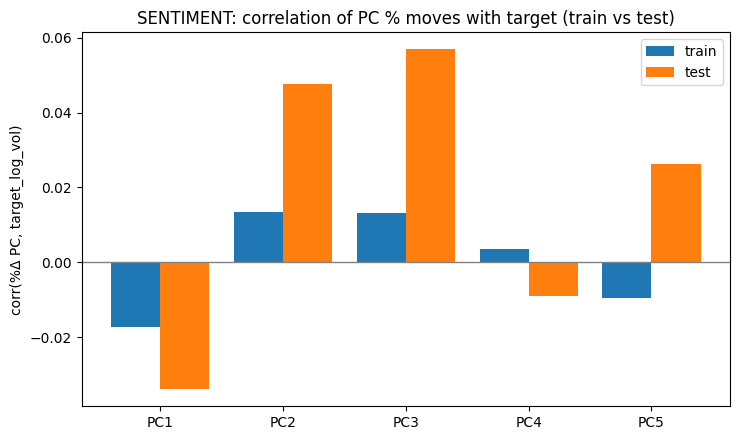

[Saved] plots/SENTIMENT_pc_pct_corr_train_vs_test.png


In [ ]:
which_cat = "SENTIMENT"
plot_df = pc_pct_corrs[pc_pct_corrs["category"].str.upper() == which_cat.upper()].copy()
if not plot_df.empty:
    plot_df = plot_df.sort_values("PC")
    plt.figure(figsize=(7.5, 4.5))
    x = np.arange(len(plot_df))
    width = 0.4
    plt.bar(x - width/2, plot_df["corr_train"], width, label="train")
    plt.bar(x + width/2, plot_df["corr_test"],  width, label="test")
    plt.axhline(0.0, color="gray", linewidth=1)
    plt.xticks(x, plot_df["PC"])
    plt.ylabel("corr(%Δ PC, target_log_vol)")
    plt.title(f"{which_cat}: correlation of PC % moves with target (train vs test)")
    plt.legend()
    plt.tight_layout()
    out_png = os.path.join(PLOTS_DIR, f"{which_cat}_pc_pct_corr_train_vs_test.png")
    plt.show()
    plt.close()
    print(f"[Saved] {out_png}")
else:
    print(f"[Info] No PCs found for category '{which_cat}'.")


In [ ]:
# Correlation of rolling volatility of PCs vs target (train & test)
import numpy as np
import pandas as pd

# --- config ---
WINDOWS = [5, 22, 30]   # horizons for rolling vol
TARGET_COL = "target_log_vol"

# train/test split
n = len(df)
n_tr = int(np.floor(n * 0.70))
n_va = int(np.floor(n * 0.15))
n_te = n - n_tr - n_va
idx_train = np.arange(0, n_tr)
idx_test  = np.arange(n_tr + n_va, n)

# --- detect PCs ---
if "all_pc_df" in globals() and isinstance(all_pc_df, pd.DataFrame) and len(all_pc_df.columns) > 0:
    pc_cols = [c for c in all_pc_df.columns if "_PC" in c]
    pcs_full = all_pc_df.reindex(df.index)
else:
    pc_cols = [c for c in df.columns if "_PC" in c]
    pcs_full = df[pc_cols].copy()

if not pc_cols:
    raise ValueError("No PC columns found (expected *_PCk).")

# --- rolling volatility of PCs ---
pc_vol_feats = {}
for col in pc_cols:
    # daily changes of the PC (signed)
    dpc = pcs_full[col].diff()
    for k in WINDOWS:
        feat_name = f"{col}_vol{k}"
        pcs_full[feat_name] = np.log(dpc.rolling(k).std() * np.sqrt(252) + 1e-12)
        pc_vol_feats.setdefault(col, []).append(feat_name)

# --- correlation helper ---
def _corr_on_slice(frame, cols, target_col, rows):
    sub = frame.loc[rows, [target_col] + cols].dropna()
    if sub.shape[0] < 5:
        return pd.Series({c: np.nan for c in cols})
    return sub.corr(numeric_only=True)[target_col].drop(labels=[target_col])

# --- compute correlations ---
all_feats = [f for feats in pc_vol_feats.values() for f in feats]
frame = pd.concat([df[[TARGET_COL]], pcs_full[all_feats]], axis=1)

corr_train = _corr_on_slice(frame, all_feats, TARGET_COL, idx_train)
corr_test  = _corr_on_slice(frame, all_feats, TARGET_COL, idx_test)

# --- tidy table ---
rows = []
for pc, feats in pc_vol_feats.items():
    for feat in feats:
        horizon = feat.split("vol")[-1]
        rows.append({
            "PC": pc,
            "horizon": horizon,
            "corr_train": float(corr_train.get(feat, np.nan)),
            "corr_test": float(corr_test.get(feat,  np.nan)),
        })

pc_vol_corrs = pd.DataFrame(rows).sort_values(["PC", "horizon"]).reset_index(drop=True)

# show & save
print(pc_vol_corrs)
pc_vol_corrs.to_csv("plots/pc_rolling_vol_vs_target_corrs.csv", index=False)
print("[Saved] plots/pc_rolling_vol_vs_target_corrs.csv")


                       PC horizon  corr_train  corr_test
0   EXCHANGE_CURRENCY_PC1      22    0.046839  -0.267103
1   EXCHANGE_CURRENCY_PC1      30    0.031455  -0.269600
2   EXCHANGE_CURRENCY_PC1       5    0.049657  -0.070101
3     EXPORT_CURRENCY_PC1      22    0.143524  -0.186598
4     EXPORT_CURRENCY_PC1      30    0.153700  -0.195061
..                    ...     ...         ...        ...
61          SENTIMENT_PC4      30    0.185525   0.271160
62          SENTIMENT_PC4       5    0.118567   0.121357
63          SENTIMENT_PC5      22    0.221976   0.031250
64          SENTIMENT_PC5      30    0.261971   0.130246
65          SENTIMENT_PC5       5    0.132157  -0.014799

[66 rows x 4 columns]
[Saved] plots/pc_rolling_vol_vs_target_corrs.csv


In [22]:
# --- tidy table ---
rows = []
for pc, feats in pc_vol_feats.items():
    for feat in feats:
        horizon = feat.split("vol")[-1]
        rows.append({
            "PC": pc,
            "horizon": int(horizon),
            "corr_train": float(corr_train.get(feat, np.nan)),
            "corr_test": float(corr_test.get(feat,  np.nan)),
        })

pc_vol_corrs = (
    pd.DataFrame(rows)
      .sort_values(["PC", "horizon"])
      .reset_index(drop=True)
)

# --- filter by abs(corr_train) >= 0.2 ---
pc_vol_corrs_filtered = pc_vol_corrs[pc_vol_corrs["corr_train"].abs() >= 0.2].reset_index(drop=True)

# show & save
print(pc_vol_corrs_filtered)
out_csv = "plots/pc_rolling_vol_vs_target_corrs_filtered.csv"
pc_vol_corrs_filtered.to_csv(out_csv, index=False)
print(f"[Saved] {out_csv}")


                    PC  horizon  corr_train  corr_test
0  IMPORT_CURRENCY_PC3       22   -0.238327   0.011098
1  IMPORT_CURRENCY_PC3       30   -0.275588   0.022595
2  IMPORT_CURRENCY_PC4       22   -0.270537   0.174831
3  IMPORT_CURRENCY_PC4       30   -0.307239   0.116196
4        SENTIMENT_PC1       22    0.279026   0.228436
5        SENTIMENT_PC1       30    0.319152   0.291295
6        SENTIMENT_PC3       30    0.235727   0.397727
7        SENTIMENT_PC5       22    0.221976   0.031250
8        SENTIMENT_PC5       30    0.261971   0.130246
[Saved] plots/pc_rolling_vol_vs_target_corrs_filtered.csv


In [23]:
pc_vol_corrs_filtered

,PC,horizon,corr_train,corr_test
0,IMPORT_CURRENCY_PC3,22,-0.238327,0.011098
1,IMPORT_CURRENCY_PC3,30,-0.275588,0.022595
2,IMPORT_CURRENCY_PC4,22,-0.270537,0.174831
3,IMPORT_CURRENCY_PC4,30,-0.307239,0.116196
4,SENTIMENT_PC1,22,0.279026,0.228436
5,SENTIMENT_PC1,30,0.319152,0.291295
6,SENTIMENT_PC3,30,0.235727,0.397727
7,SENTIMENT_PC5,22,0.221976,0.031250
8,SENTIMENT_PC5,30,0.261971,0.130246


[Saved] plots/pc_rolling_vol_vs_target_corrs_for_plot.csv


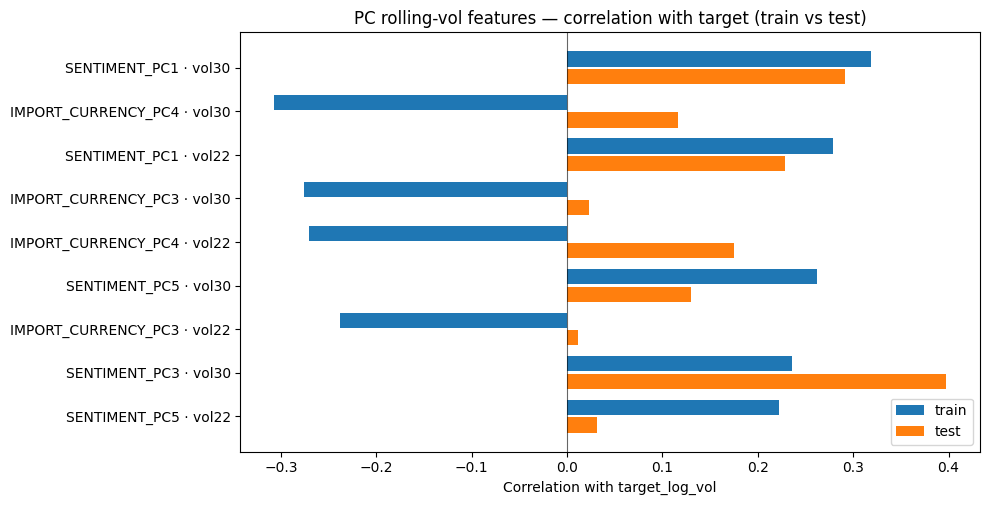

[Saved] plots/pc_rolling_vol_corrs_barh.png


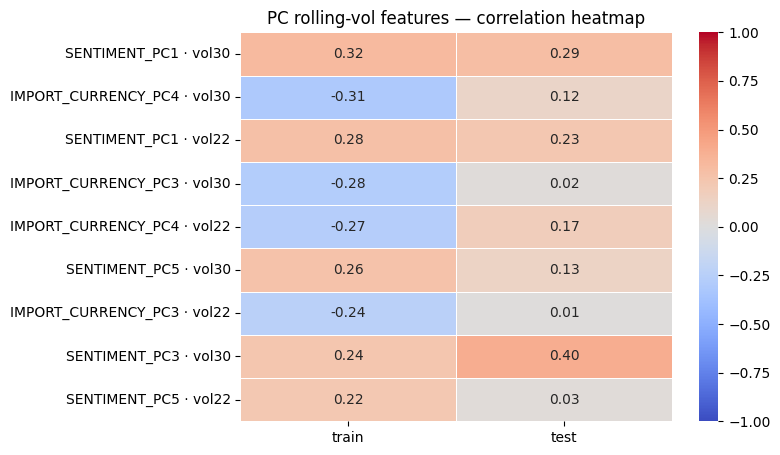

[Saved] plots/pc_rolling_vol_corrs_heatmap.png


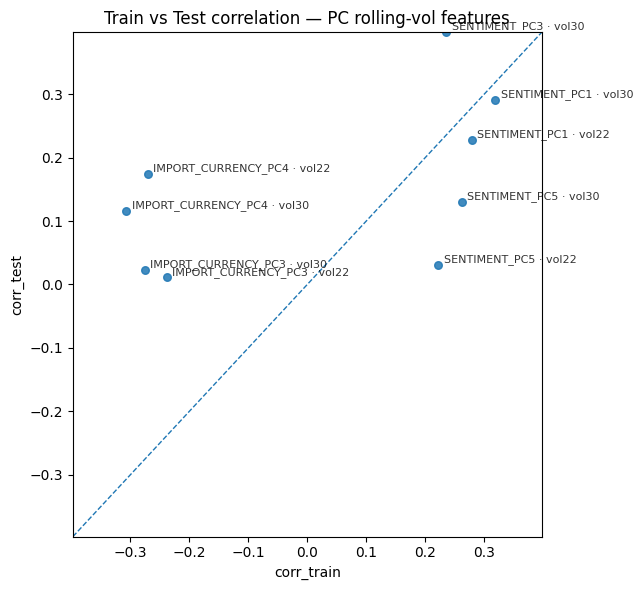

[Saved] plots/pc_rolling_vol_corrs_scatter.png


In [ ]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

# Use filtered table if present, else fall back to full
_df = pc_vol_corrs_filtered if 'pc_vol_corrs_filtered' in globals() else pc_vol_corrs
dfp = _df.copy()

# Normalize/guard against non-finite values
for c in ["corr_train", "corr_test"]:
    if c in dfp.columns:
        dfp[c] = pd.to_numeric(dfp[c], errors="coerce").replace([np.inf, -np.inf], np.nan)

# Drop rows where BOTH train & test are NaN
dfp = dfp[~(dfp["corr_train"].isna() & dfp["corr_test"].isna())].reset_index(drop=True)

# Build a label like "PC1 · vol5" (or "Sentiment_PC1 · vol5" if your PC names are strings)
dfp["feature"] = dfp.apply(lambda r: f"{r['PC']} · vol{int(r['horizon'])}", axis=1)

# Sort by |train| descending (NaNs pushed to bottom)
dfp["_abs_tr"] = dfp["corr_train"].abs()
dfp = dfp.sort_values("_abs_tr", ascending=False).drop(columns="_abs_tr").reset_index(drop=True)

# Save a clean CSV for this plotting subset (in case you filtered earlier)
plot_csv = os.path.join(PLOTS_DIR, "pc_rolling_vol_vs_target_corrs_for_plot.csv")
dfp.to_csv(plot_csv, index=False)
print(f"[Saved] {plot_csv}")

# -------------------------- 1) Horizontal grouped bar plot (train vs test) --------------------------
labels = dfp["feature"].tolist()
ypos   = np.arange(len(labels))

bar_h  = 0.35
sep    = bar_h * 0.15

tr_vals = dfp["corr_train"].to_numpy()
te_vals = dfp["corr_test"].to_numpy()

fig, ax = plt.subplots(figsize=(10, max(4, 0.35*len(labels) + 2)))
ax.barh(ypos - (bar_h/2 + sep/2), tr_vals, height=bar_h, label="train")
ax.barh(ypos + (bar_h/2 + sep/2), te_vals, height=bar_h, label="test")

ax.set_yticks(ypos)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel("Correlation with target_log_vol")
ax.set_title("PC rolling-vol features — correlation with target (train vs test)")

# vertical zero line
ax.axvline(0.0, color="k", linewidth=0.8, alpha=0.6)
ax.legend(loc="lower right")
plt.tight_layout()
out_png = os.path.join(PLOTS_DIR, "pc_rolling_vol_corrs_barh.png")
plt.savefig(out_png, dpi=160)
plt.show()
print(f"[Saved] {out_png}")

# -------------------------- 2) Optional heatmap (if seaborn available) --------------------------
if _HAS_SNS and len(dfp) > 0:
    mat = dfp.set_index("feature")[["corr_train", "corr_test"]].rename(
        columns={"corr_train": "train", "corr_test": "test"}
    )

    plt.figure(figsize=(8, max(3, 0.35*len(mat) + 1.5)))
    sns.heatmap(
        mat, annot=True, fmt=".2f", cmap="coolwarm",
        vmin=-1, vmax=1, linewidths=0.5, cbar=True
    )
    plt.title("PC rolling-vol features — correlation heatmap")
    plt.xlabel(""); plt.ylabel("")
    plt.tight_layout()
    out_png_hm = os.path.join(PLOTS_DIR, "pc_rolling_vol_corrs_heatmap.png")
    plt.savefig(out_png_hm, dpi=160)
    plt.show()
    print(f"[Saved] {out_png_hm}")

# -------------------------- 3) Optional scatter (over/under-fitting glance) --------------------------
# Points near the diagonal indicate similar behavior in train and test.
valid = dfp.dropna(subset=["corr_train", "corr_test"])
if len(valid) >= 2:
    x = valid["corr_train"].to_numpy()
    y = valid["corr_test"].to_numpy()
    lbls = valid["feature"].tolist()

    plt.figure(figsize=(6.5, 6))
    plt.scatter(x, y, s=30, alpha=0.85)
    # y=x reference
    lim = np.nanmax(np.abs([x, y])) if np.isfinite([x, y]).any() else 1.0
    lim = max(0.1, float(lim))
    plt.plot([-lim, lim], [-lim, lim], linestyle="--", linewidth=1)
    plt.xlim(-lim, lim); plt.ylim(-lim, lim)
    plt.xlabel("corr_train"); plt.ylabel("corr_test")
    plt.title("Train vs Test correlation — PC rolling-vol features")

    # light label nudges (avoid clutter on many points)
    if len(lbls) <= 20:
        for xi, yi, t in zip(x, y, lbls):
            if np.isfinite(xi) and np.isfinite(yi):
                plt.annotate(t, (xi, yi), xytext=(4, 2), textcoords="offset points", fontsize=8, alpha=0.8)

    plt.tight_layout()
    out_png_sc = os.path.join(PLOTS_DIR, "pc_rolling_vol_corrs_scatter.png")
    plt.savefig(out_png_sc, dpi=160)
    plt.show()
    print(f"[Saved] {out_png_sc}")


[Saved] plots/train_correlations_engineered_plus_pcvol.csv


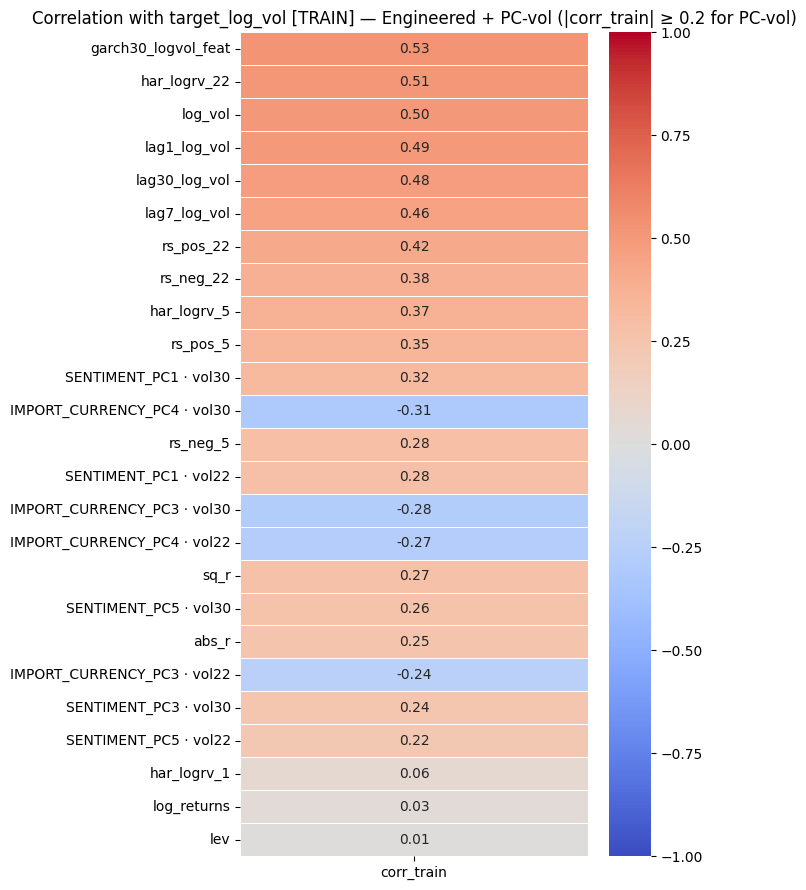

[Saved] plots/train_corrs_engineered_plus_pcvol_heatmap.png


In [ ]:
import os, numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

# ----- 1) Engineered features — train correlations (recompute on train slice) -----
engineered_cols = [
    "abs_r","sq_r","lev",
    "rs_neg_5","rs_pos_5","rs_neg_22","rs_pos_22",
    "har_logrv_1","har_logrv_5","har_logrv_22",
    "log_vol","lag1_log_vol","lag7_log_vol","lag30_log_vol",
    "log_returns","garch30_logvol_feat"
]
engineered_cols = [c for c in engineered_cols if c in df.columns]

sub_tr_eng = df.loc[idx_train, engineered_cols + ["target_log_vol"]].dropna()
corr_eng_tr = (
    sub_tr_eng.corr(numeric_only=True)["target_log_vol"]
              .drop("target_log_vol", errors="ignore")
)

# ----- 2) PC rolling-vol features from pc_vol_corrs_filtered (train only, corr>=0.2) -----
if 'pc_vol_corrs_filtered' in globals():
    pc_tab = pc_vol_corrs_filtered.copy()
elif 'pc_vol_corrs' in globals():
    pc_tab = pc_vol_corrs.copy()
else:
    pc_tab = pd.DataFrame(columns=["PC","horizon","corr_train"])

# coerce and filter by threshold; drop NaNs
pc_tab["corr_train"] = pd.to_numeric(pc_tab.get("corr_train", np.nan), errors="coerce")
pc_tab["horizon"]    = pd.to_numeric(pc_tab.get("horizon", np.nan), errors="coerce").astype("Int64")

pc_tab = pc_tab[pc_tab["corr_train"].abs() >= 0.2].dropna(subset=["corr_train","PC","horizon"]).reset_index(drop=True)

# Build a readable label like "PC1 · vol5" (keep it purely a label — no reliance on df column names)
pc_labels  = [f"{row.PC} · vol{int(row.horizon)}" for row in pc_tab.itertuples(index=False)]
pc_values  = pc_tab["corr_train"].to_numpy(dtype=float)
pc_series  = pd.Series(pc_values, index=pc_labels, name="corr_train")

# ----- 3) Combine engineered + PC-vol (train) and plot -----
corr_all_tr = pd.concat([corr_eng_tr, pc_series], axis=0)

# Order by absolute correlation (train)
corr_all_tr = corr_all_tr.sort_values(key=lambda s: s.abs(), ascending=False)

# Save CSV
out_csv = os.path.join(PLOTS_DIR, "train_correlations_engineered_plus_pcvol.csv")
corr_all_tr.to_csv(out_csv, header=["corr_with_target_train"])
print(f"[Saved] {out_csv}")

# Plot (heatmap if seaborn available, else barh)
title = "Correlation with target_log_vol [TRAIN] — Engineered + PC-vol (|corr_train| ≥ 0.2 for PC-vol)"
fig_h = 0.3 * max(len(corr_all_tr), 5) + 1.5
fig_w = 7

if _HAS_SNS:
    plt.figure(figsize=(fig_w, fig_h))
    sns.heatmap(
        corr_all_tr.to_frame(name="corr_train"),
        annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, cbar=True, linewidths=0.5
    )
    plt.title(title); plt.xlabel(""); plt.ylabel("")
    plt.tight_layout()
    out_png = os.path.join(PLOTS_DIR, "train_corrs_engineered_plus_pcvol_heatmap.png")
    plt.savefig(out_png, dpi=160)
    plt.show()
    print(f"[Saved] {out_png}")
else:
    plt.figure(figsize=(fig_w, fig_h))
    y = np.arange(len(corr_all_tr))
    plt.barh(y, corr_all_tr.values)
    plt.yticks(y, corr_all_tr.index)
    plt.gca().invert_yaxis()
    plt.xlabel("corr_train")
    plt.title(title)
    # vertical zero line
    plt.axvline(0.0, linewidth=0.8, alpha=0.6)
    plt.tight_layout()
    out_png = os.path.join(PLOTS_DIR, "train_corrs_engineered_plus_pcvol_barh.png")
    plt.savefig(out_png, dpi=160)
    plt.show()
    print(f"[Saved] {out_png}")
